In [1]:
import json
import pandas as pd
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('mpd.slice.0-999.json', 'r') as json_file:
    playlistData = json.load(json_file)
with open('songs_0-999.json', 'r') as json_file:
    songData = json.load(json_file)
with open('artists_0-999.json', 'r') as json_file:
    artistData = json.load(json_file)
with open('albums_0-999.json', 'r') as json_file:
    albumData = json.load(json_file)

In [3]:
playlistData['playlists'][999]

{'name': 'thinking of you',
 'collaborative': 'false',
 'pid': 999,
 'modified_at': 1507766400,
 'num_tracks': 44,
 'num_albums': 43,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'Pvris',
   'track_uri': 'spotify:track:3rUTBx7gmn1IAAwsrjtnO0',
   'artist_uri': 'spotify:artist:6oFs3qk4VepIVFdoD4jmsy',
   'track_name': 'Mind over Matter (Acoustic)',
   'album_uri': 'spotify:album:33oxbqzo7poSO2IbSMqrPS',
   'duration_ms': 203649,
   'album_name': 'Acoustic'},
  {'pos': 1,
   'artist_name': 'Ingrid Michaelson',
   'track_uri': 'spotify:track:6zYqyOJuyXDOvWJwKkZ8tg',
   'artist_uri': 'spotify:artist:2vm8GdHyrJh2O2MfbQFYG0',
   'track_name': 'You and I',
   'album_uri': 'spotify:album:7o2VLivg95UduHjTMTIEIf',
   'duration_ms': 148400,
   'album_name': 'Be OK'},
  {'pos': 2,
   'artist_name': 'Troye Sivan',
   'track_uri': 'spotify:track:0nRuVPZx2iA3KWR4xSzryl',
   'artist_uri': 'spotify:artist:3WGpXCj9YhhfX11TToZcXP',
   'track_name': 'TALK ME DOWN',
   'album_uri': 'spotif

In [4]:
artistData['2wIVse2owClT7go1WT98tk']['genres']

['dance pop',
 'hip hop',
 'hip pop',
 'neo soul',
 'pop rap',
 'r&b',
 'rap',
 'urban contemporary',
 'virginia hip hop']

In [10]:
def findGenresAndArtist(track):
    artist = track['artist_uri']
    artist = artist.split(':')[2]
    if artist in artistData:
        genres = artistData[artist]['genres']
    else:
        genres = []
    return genres, artist

def findModes(lst, n):
    counter = Counter(lst)
    modes = counter.most_common(n)
    return [mode[0] for mode in modes]

def getPlaylistArtists(playlist, modes):
    allArtists = []
    for track in playlist['tracks']:
        artist = track['artist_uri']
        artist = artist.split(':')[2]
        allArtists.append(artist)
    topArtists = findModes(allArtists, modes)
    return topArtists
    
def getPlaylistGenres(playlist, modes):
    allGenres = []
    for track in playlist['tracks']:
        genres, a = findGenresAndArtist(track)
        for g in genres:
            allGenres.append(g)
    topGenres = findModes(allGenres, modes)
    return topGenres

In [17]:
playlistInfo = []
for playlist in playlistData['playlists']:
    genres = []
    artists = []
    for track in playlist['tracks']:
        gs, artist = findGenresAndArtist(track)
        artists.append(artist)
        for g in gs:
            genres.append(g)
    playlistInfo.append([playlist['pid'], genres, artists])

#FIX THIS, ONLY COUNTS ONE PLAYLIST NOT ALL
allGenres = playlistInfo[1]
allDifGenres = []
for g in allGenres:
    if not g in allDifGenres:
        allDifGenres.append(g)

allArtists = playlistInfo[2]
allDifArtists = []
for a in allArtists:
    if not g in allDifArtists:
        allDifArtists.append(a)

In [18]:
allDifArtists

[2,
 ['korean r&b',
  'k-pop',
  'k-rap',
  'korean r&b',
  'korean pop',
  'korean pop',
  'k-pop',
  'k-pop boy group',
  'pop',
  'k-pop',
  'k-pop girl group',
  'k-pop',
  'k-pop',
  'k-pop',
  'k-pop',
  'k-pop',
  'k-rap',
  'korean r&b',
  'k-pop',
  'k-rap',
  'korean r&b',
  'k-pop',
  'k-pop',
  'k-pop',
  'k-rap',
  'korean r&b',
  'k-pop',
  'k-rap',
  'korean r&b',
  'k-pop',
  'k-rap',
  'korean r&b',
  'k-pop',
  'k-rap',
  'korean r&b',
  'k-pop',
  'korean r&b',
  'k-pop',
  'k-pop',
  'k-pop',
  'k-rap',
  'korean r&b',
  'k-pop',
  'k-pop boy group',
  'pop',
  'k-pop',
  'k-pop girl group',
  'pop',
  'k-pop',
  'korean pop',
  'korean singer-songwriter',
  'korean pop',
  'korean pop',
  'k-pop',
  'k-pop boy group',
  'k-pop',
  'k-pop boy group',
  'k-pop',
  'k-rap',
  'korean r&b',
  'k-pop',
  'k-pop girl group',
  'k-pop',
  'k-pop girl group',
  'k-pop',
  'k-pop',
  'k-pop',
  'j-division',
  'korean ost',
  'k-pop',
  'k-pop boy group',
  'k-pop',
  'k-po

In [7]:
def getFrequency(allList, obj):
    count = 0
    for x in allList:
        if x == obj:
            count += 1
    frequency = round(count/len(allList), 5)
    return frequency

In [8]:
# artistFrequencies = []
# for artist in allDifArtists:
#     frequency = getFrequency(allArtists, artist)
#     artistFrequencies.append([artist, frequency])
    
# genreFrequencies = []
# for genre in allDifGenres:
#     frequency = getFrequency(allGenres, genre)
#     genreFrequencies.append([genre, frequency])

In [11]:
allPlaylistInfo = pd.DataFrame()
for playlist in playlistData['playlists']:
    genres = getPlaylistGenres(playlist, 3)
    gfs = []
    for g in genres:
        f = getFrequency(allGenres, g)
        gfs.append(f)
    artists = getPlaylistArtists(playlist, 3)
    afs = []
    for a in artists:
        f = getFrequency(allArtists, a)
        afs.append(f)
    row = pd.DataFrame({'playlist': [playlist['pid']],
           'genres': [genres],
           'genreFrequencies_sum':[sum(gfs)],
           'genreFrequencies_mean': [(sum(gfs)/len(gfs))],
           'artists': [artists],
           'artistFrequencies_sum':[sum(afs)],
           'artistFrequencies_mean': [(sum(afs)/len(afs))]})
    allPlaylistInfo = pd.concat([allPlaylistInfo, row], ignore_index=True).reset_index(drop=True)
    
allPlaylistInfo2 = pd.DataFrame()
for playlist in playlistData['playlists']:
    genres = getPlaylistGenres(playlist, 3)
    gfs = []
    for g in genres:
        f = getFrequency(allGenres, g)
        gfs.append(f)
    artists = getPlaylistArtists(playlist, 3)
    afs = []
    for a in artists:
        f = getFrequency(allArtists, a)
        afs.append(f)
    row = pd.DataFrame({'playlist': [playlist['pid']],
           'genres': [genres],
           'genreFrequencies_sum':[sum(gfs)],
           'genreFrequencies_mean': [(sum(gfs)/len(gfs))],
           'artists': [artists],
           'artistFrequencies_sum':[sum(afs)],
           'artistFrequencies_mean': [(sum(afs)/len(afs))]})
    allPlaylistInfo2 = pd.concat([allPlaylistInfo2, row], ignore_index=True).reset_index(drop=True)

In [12]:
allPlaylistInfo.head()

,playlist,genres,genreFrequencies_sum,genreFrequencies_mean,artists,artistFrequencies_sum,artistFrequencies_mean
0,0,"[pop, dance pop, r&b]",0.0,0.0,"[2Hjj68yyUPiC0HKEOigcEp, 7bXgB6jMjp9ATFy66eO08...",0.00790,0.002633
1,1,"[rock, album rock, classic rock]",0.0,0.0,"[2Hkut4rAAyrQxRdof7FVJq, 7zdmbPudNX4SQJXnYIuCT...",0.00075,0.000250
2,2,"[k-pop, k-pop boy group, korean r&b]",0.0,0.0,"[3Nrfpe0tUJi4K4DXYWgMUX, 4XDi67ZENZcbfKnvMnTYs...",0.00076,0.000253
3,3,"[indie rock, noise pop, indie garage rock]",0.0,0.0,"[5juac7bFYyLKmV0VGSyaKM, 2JSc53B5cQ31m0xTB7JFp...",0.00027,0.000090
4,4,"[pop rock, permanent wave, rock]",0.0,0.0,"[40Yq4vzPs9VNUrIBG5Jr2i, 2DaxqgrOhkeH0fpeiQq2f...",0.00206,0.000687


In [13]:
allPlaylistInfo2.head()

,playlist,genres,genreFrequencies_sum,genreFrequencies_mean,artists,artistFrequencies_sum,artistFrequencies_mean
0,0,"[pop, dance pop, r&b]",0.0,0.0,"[2Hjj68yyUPiC0HKEOigcEp, 7bXgB6jMjp9ATFy66eO08...",0.00790,0.002633
1,1,"[rock, album rock, classic rock]",0.0,0.0,"[2Hkut4rAAyrQxRdof7FVJq, 7zdmbPudNX4SQJXnYIuCT...",0.00075,0.000250
2,2,"[k-pop, k-pop boy group, korean r&b]",0.0,0.0,"[3Nrfpe0tUJi4K4DXYWgMUX, 4XDi67ZENZcbfKnvMnTYs...",0.00076,0.000253
3,3,"[indie rock, noise pop, indie garage rock]",0.0,0.0,"[5juac7bFYyLKmV0VGSyaKM, 2JSc53B5cQ31m0xTB7JFp...",0.00027,0.000090
4,4,"[pop rock, permanent wave, rock]",0.0,0.0,"[40Yq4vzPs9VNUrIBG5Jr2i, 2DaxqgrOhkeH0fpeiQq2f...",0.00206,0.000687


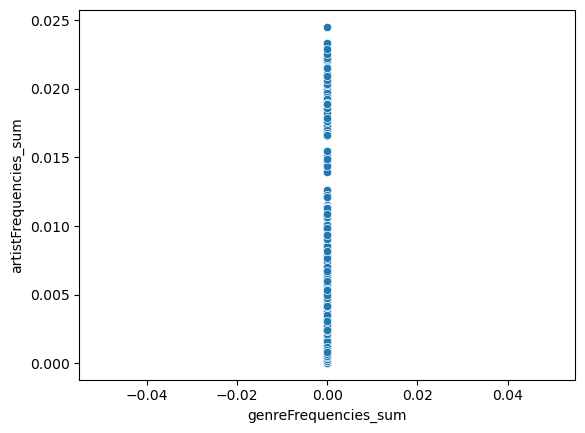

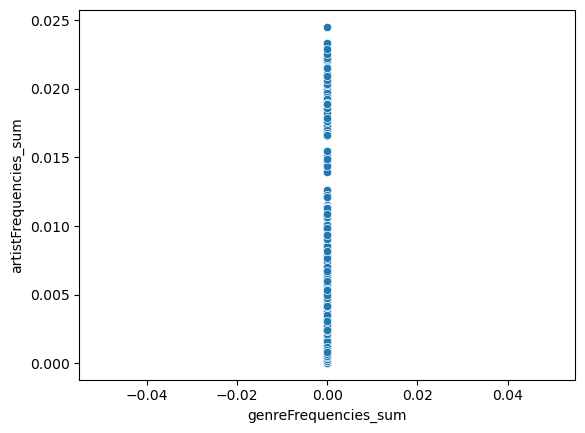

In [14]:
sns.scatterplot(data=allPlaylistInfo, x='genreFrequencies_sum', y='artistFrequencies_sum')
plt.show()
sns.scatterplot(data=allPlaylistInfo2, x='genreFrequencies_sum', y='artistFrequencies_sum')
plt.show()